In [1151]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

You can change these parameters to test different datasets, filters, and slices:

- `original_filename`: Path to the original input data file.
- `wavelet_name`: Type of wavelet to use (e.g., 'db2').
- `levels`: Number of levels for the wavelet transform.
- `slice`: Slice to observe (along depth).

In [1152]:
# Read the original input data
original_filename = '../data/3.bin'

# Type of wavelet to use
wavelet_name = 'db1'

# Number of levels 
levels = 4

# Slice to observe (along depth)
slice = 0

This Python script performs a comparison of each level of the Discrete Wavelet Transform (DWT). It plots the subbands and calculates the Mean Squared Error (MSE) for all subbands as well as the MSE of the total energy. Additionally, it displays the resolutions of each subband at each level.

In [1153]:
# Read the shape of the original data
def read_shape_file(shape_filename):
    with open(shape_filename, 'r') as f:
        shape = tuple(map(int, f.read().strip().split(',')))
    return shape

# Read the original data
def read_binary_file(filename):
    # Determine the shape file name based on the binary file name
    shape_filename = filename.rsplit('.', 1)[0] + "_shape.txt"
    
    # Read the shape information
    depth, rows, cols = read_shape_file(shape_filename)
    print(f"Read dimensions from shape file: depth={depth}, rows={rows}, cols={cols}")
    
    # Read the binary file
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float32)
        print(f"Read data size: {data.size}")
        
        data = data.reshape((depth, rows, cols))
        
    return data

# Read the result of the C++ implementation
def read_wavelet3d_result(filename):
    # Determine the output file name by appending "out" to the input file name
    output_filename = "../serial/outputs/" + filename.rsplit('/', 1)[-1].rsplit('.', 1)[0] + "out." + filename.rsplit('.', 1)[1]
    
    subbands = {}
    with open(output_filename, 'rb') as file:
        for key in ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']:
            depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            data = np.fromfile(file, dtype=np.float32, count=depth*rows*cols)
            data = data.reshape((depth, rows, cols))
            subbands[key] = data
    return subbands

In [1154]:
# Normalise the data so that it is more visually appealing
def normalise_plot(data):
    normalized_data = np.abs(data) / np.max(np.abs(data))
    return normalized_data

# Normalise the data to be of even scale
def normalise_data(data):
    mean = np.mean(data)
    std = np.std(data)
    if std != 0:
        data = (data - mean) / std
    return data

# Function to pad arrays to match shapes
def pad(array, target_shape):
    pad_width = [(0, max(0, t - s)) for s, t in zip(array.shape, target_shape)]
    return np.pad(array, pad_width, mode='constant')

# Display the different subbands
def display_images(data, title, keys, slice):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)

    for i, key in enumerate(keys):
        if key not in data:
            print(f"Key '{key}' not found in data")
            continue
        # Compare the slice of your choice along the depth dimension
        value = data[key][slice] 
        value = normalise_plot(value)
        ax = axes[i // 4, i % 4]
        ax.imshow(value, cmap='gray')
        ax.set_title(f'{title} - {key}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Perform the multi-level 3D wavelet transform using PyWavelets
def multi_pywt_3d(data, wavelet, mode, levels):
    coeffs = pywt.wavedecn(data, wavelet=wavelet, mode=mode, level=levels)
    return coeffs



In [1155]:
# Print filter coefficients
wavelet = pywt.Wavelet(wavelet_name)
print(f"Low-pass filter coefficients for {wavelet_name}: {wavelet.dec_lo}")
print(f"High-pass filter coefficients for {wavelet_name}: {wavelet.dec_hi}")

Low-pass filter coefficients for db1: [0.7071067811865476, 0.7071067811865476]
High-pass filter coefficients for db1: [-0.7071067811865476, 0.7071067811865476]


In [1156]:
# Read the original data
original_data = read_binary_file(original_filename)

# Perform the multi-level 3D wavelet transform using PyWavelets
coeffs_pywt = multi_pywt_3d(original_data, wavelet=wavelet_name, mode='periodization', levels=levels)

# Read the results from the C++ implementation
data_cpp = read_wavelet3d_result(original_filename)

Read dimensions from shape file: depth=78, rows=512, cols=512
Read data size: 20447232


Key 'aaa' not found in data


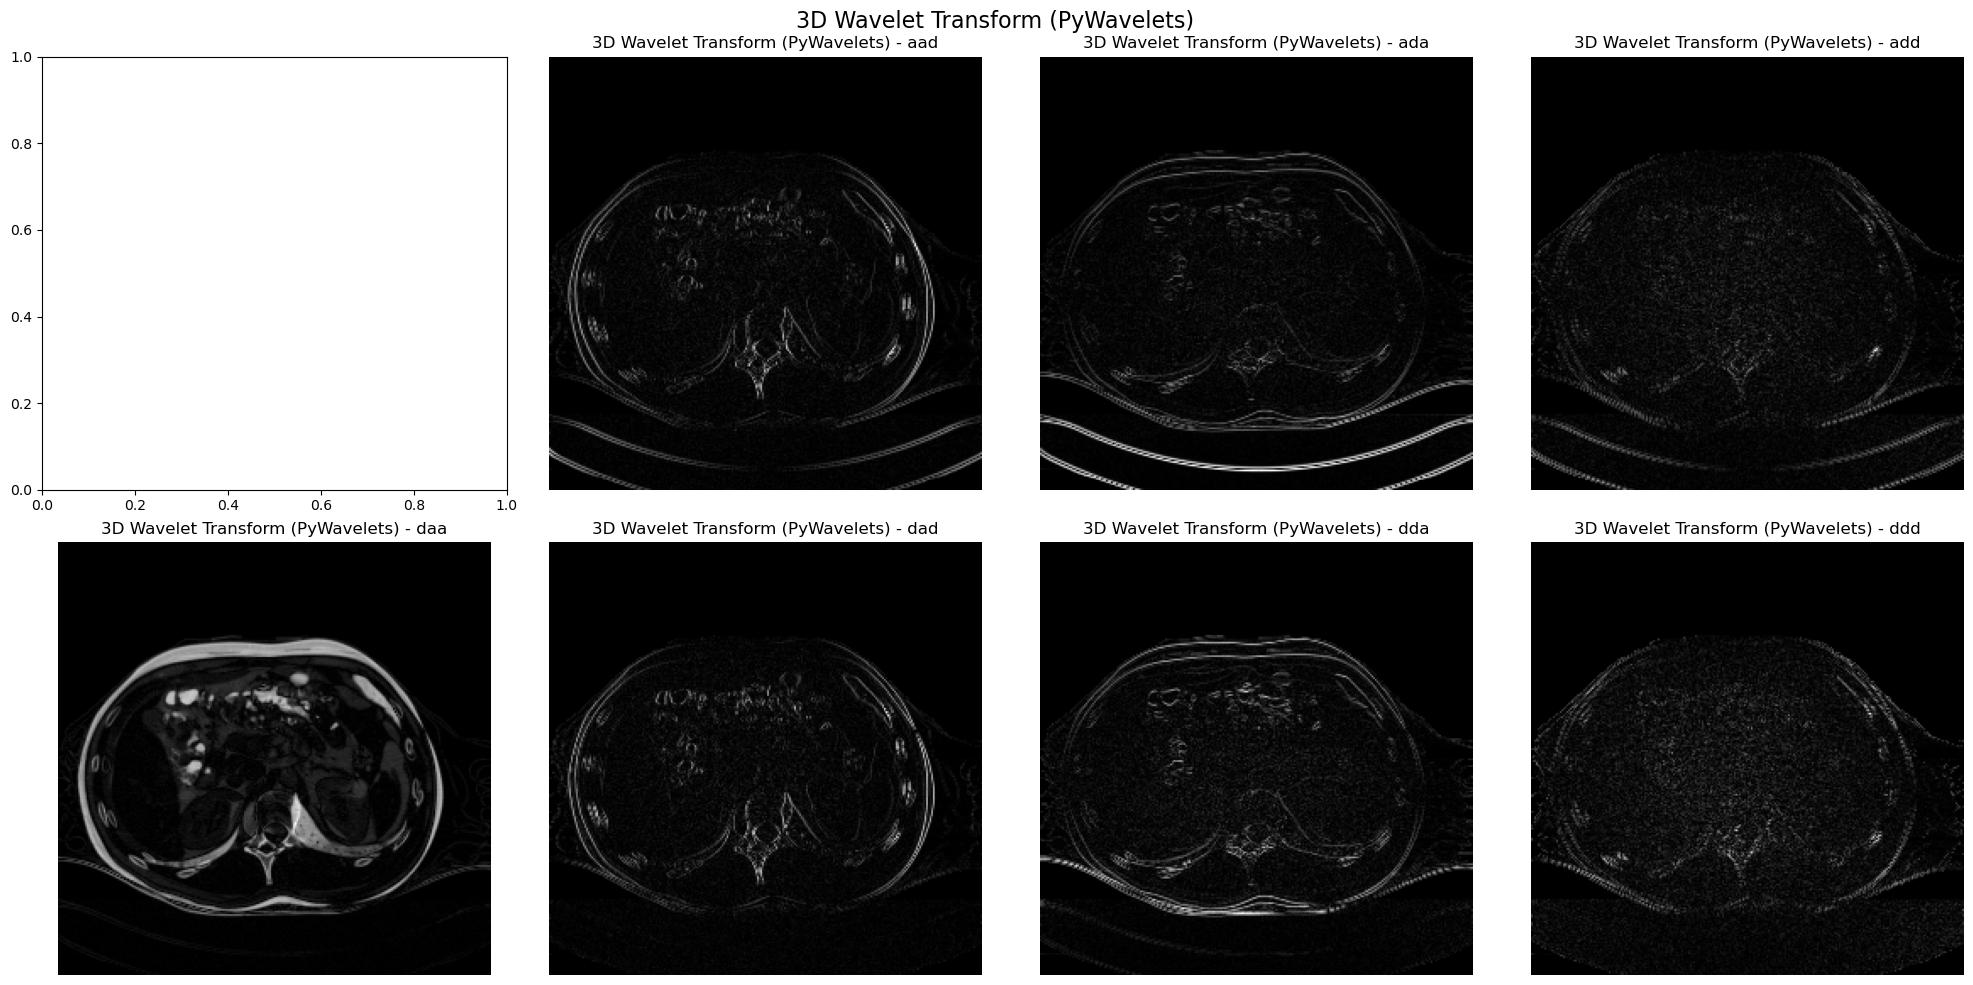

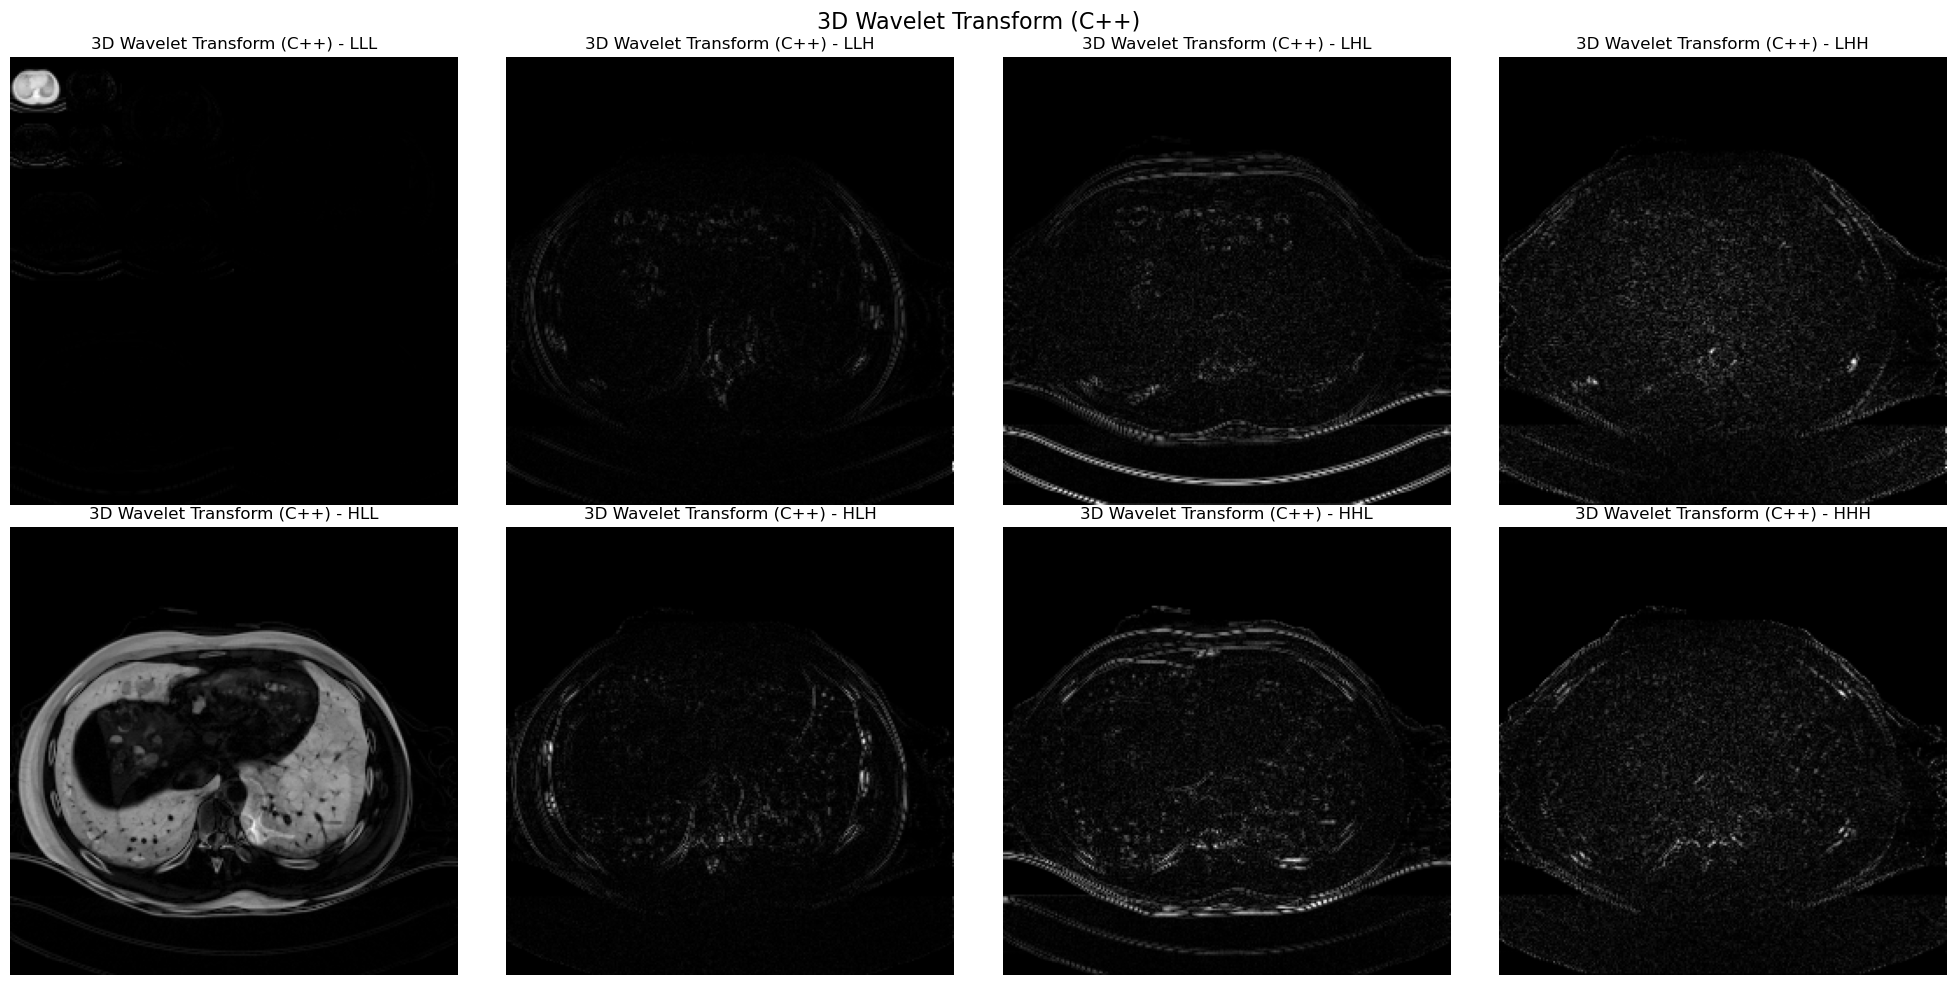

In [1157]:
# Extract the subbands from the first level
pywt = coeffs_pywt[levels]

# If we only have one level, extract the aaa subband
if levels == 1:
    pywt_aaa = coeffs_pywt[0]  # Extract the aaa subband

    # Add the aaa subband to pywt for display
    pywt['aaa'] = pywt_aaa

# Display the pywavlet's subbands related to this level 
display_images(pywt, '3D Wavelet Transform (PyWavelets)', keys=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'], slice=slice)

# Display the C++ implementation's subbands related to this level 
display_images(data_cpp, '3D Wavelet Transform (C++)', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'], slice=slice)

In [1158]:
# Copy the data to new arrays
data_cpp_copy = {key: np.copy(value) for key, value in data_cpp.items()}
coeffs_pywt_copy = {key: np.copy(value) for key, value in pywt.items()}

# Normalise the pywavelets data
for key in coeffs_pywt_copy:
    coeffs_pywt_copy[key] = normalise_data(coeffs_pywt_copy[key])

# Normalise the data
for key in data_cpp_copy:
    data_cpp_copy[key] = normalise_data(data_cpp_copy[key])

# Map between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare pywavlets and C++ results
total_energy_cpp = 0
total_energy_pywt = 0
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data_copy = data_cpp_copy[cpp_key]
        pywt_data_copy = coeffs_pywt_copy[pywt_key]
        
        # Pad arrays to match shapes if necessary
        if cpp_data_copy.shape != pywt_data_copy.shape:
            if cpp_data_copy.shape < pywt_data_copy.shape:
                cpp_data_copy = pad(cpp_data_copy, pywt_data_copy.shape)
            else:
                pywt_data_copy = pad(pywt_data_copy, cpp_data_copy.shape)
        
        mse = np.mean((cpp_data_copy - pywt_data_copy) ** 2)
        print(f"MSE for {cpp_key}: {mse}")
        
        # Calculate total energy
        total_energy_cpp += np.sum(cpp_data_copy ** 2)
        total_energy_pywt += np.sum(pywt_data_copy ** 2)
    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")

# Calculate MSE of total energy
total_energy_mse = np.mean((total_energy_cpp - total_energy_pywt) ** 2)
print(f"\nMSE of total energy: {total_energy_mse}")

KeyError: 'aaa' for key LLL
MSE for LLH: 3.0466485023498535
MSE for LHL: 3.317180633544922
MSE for LHH: 1.4960230588912964
MSE for HLL: 1.9253274202346802
MSE for HLH: 2.1340267658233643
MSE for HHL: 2.0946104526519775
MSE for HHH: 1.9426686763763428

MSE of total energy: 1.0


In [1159]:
print ("Resolution of subbands from PyWavelets:")

# Printing the resolution of the subbands
for key, value in pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

print ("\nResolution of subbands from C++:")

for key, value in data_cpp.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subbands from PyWavelets:
Resolution of subband aad: (39, 256, 256)
Resolution of subband ada: (39, 256, 256)
Resolution of subband add: (39, 256, 256)
Resolution of subband daa: (39, 256, 256)
Resolution of subband dad: (39, 256, 256)
Resolution of subband dda: (39, 256, 256)
Resolution of subband ddd: (39, 256, 256)

Resolution of subbands from C++:
Resolution of subband LLL: (39, 256, 256)
Resolution of subband LLH: (39, 256, 256)
Resolution of subband LHL: (39, 256, 256)
Resolution of subband LHH: (39, 256, 256)
Resolution of subband HLL: (39, 256, 256)
Resolution of subband HLH: (39, 256, 256)
Resolution of subband HHL: (39, 256, 256)
Resolution of subband HHH: (39, 256, 256)


Key 'aaa' not found in data


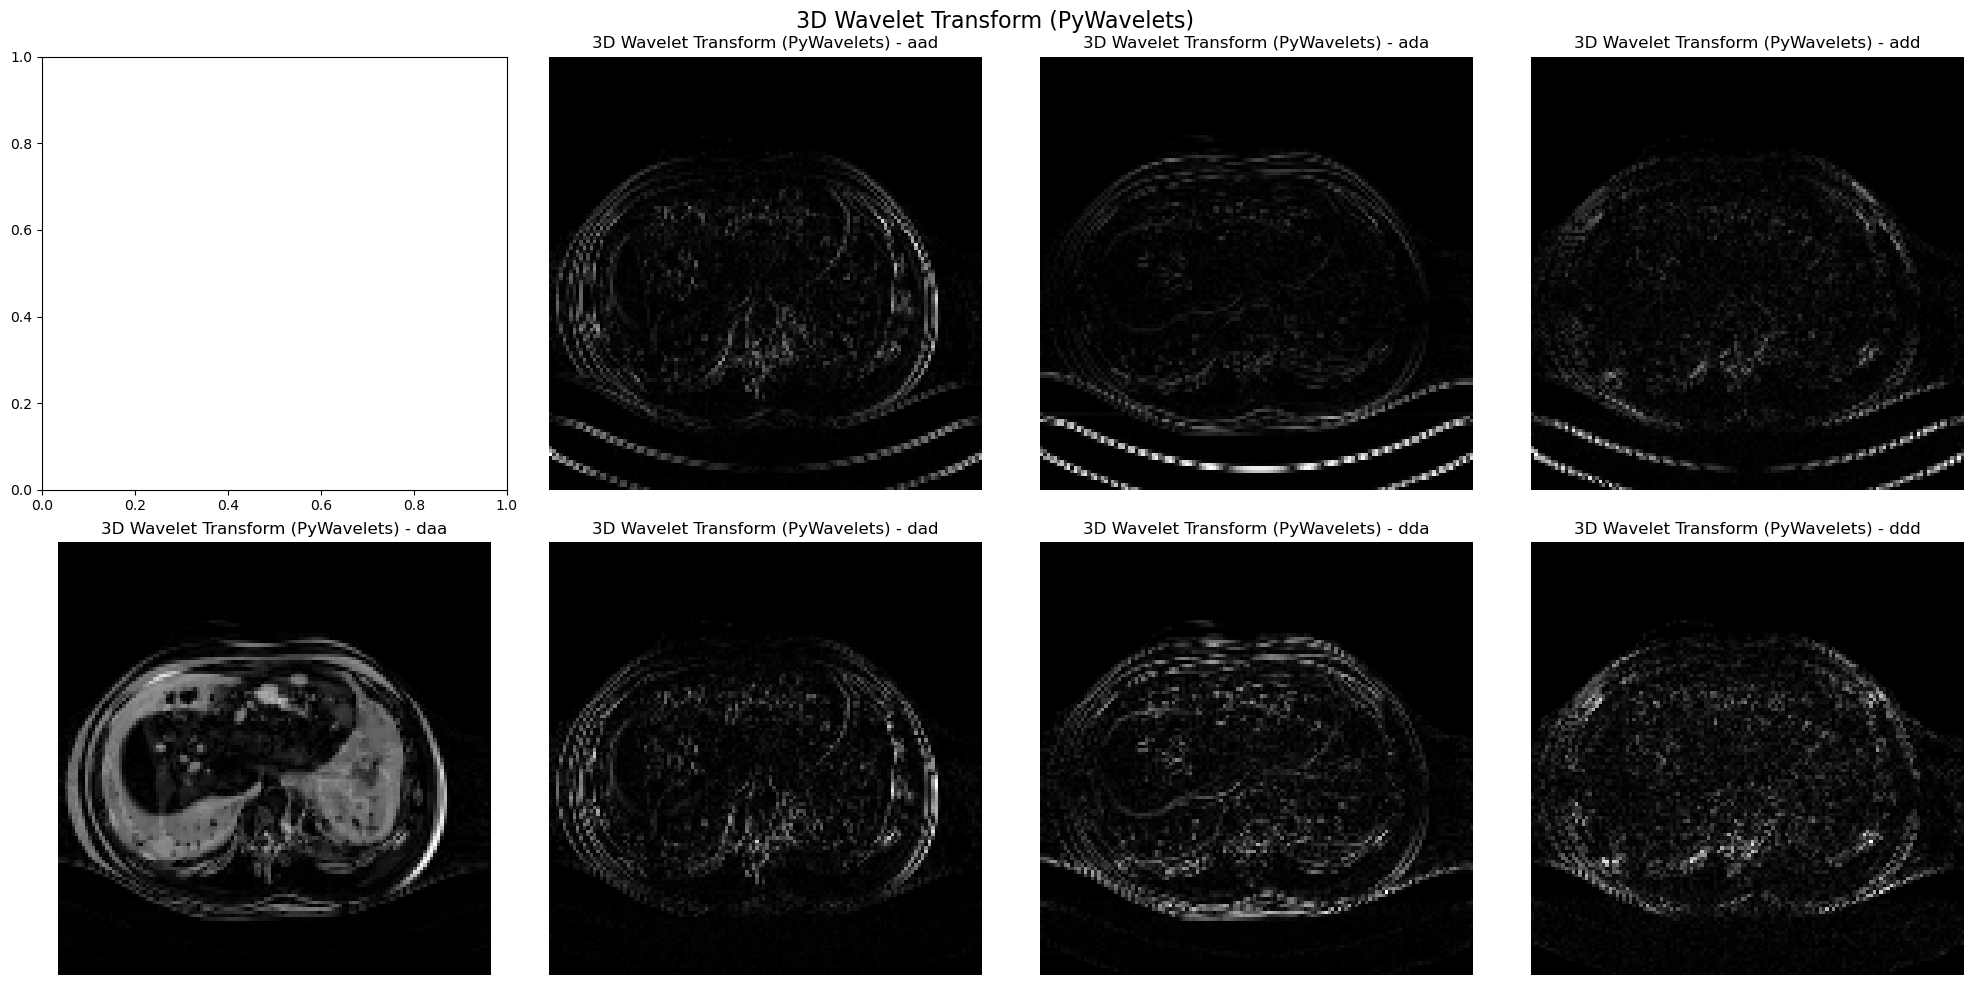

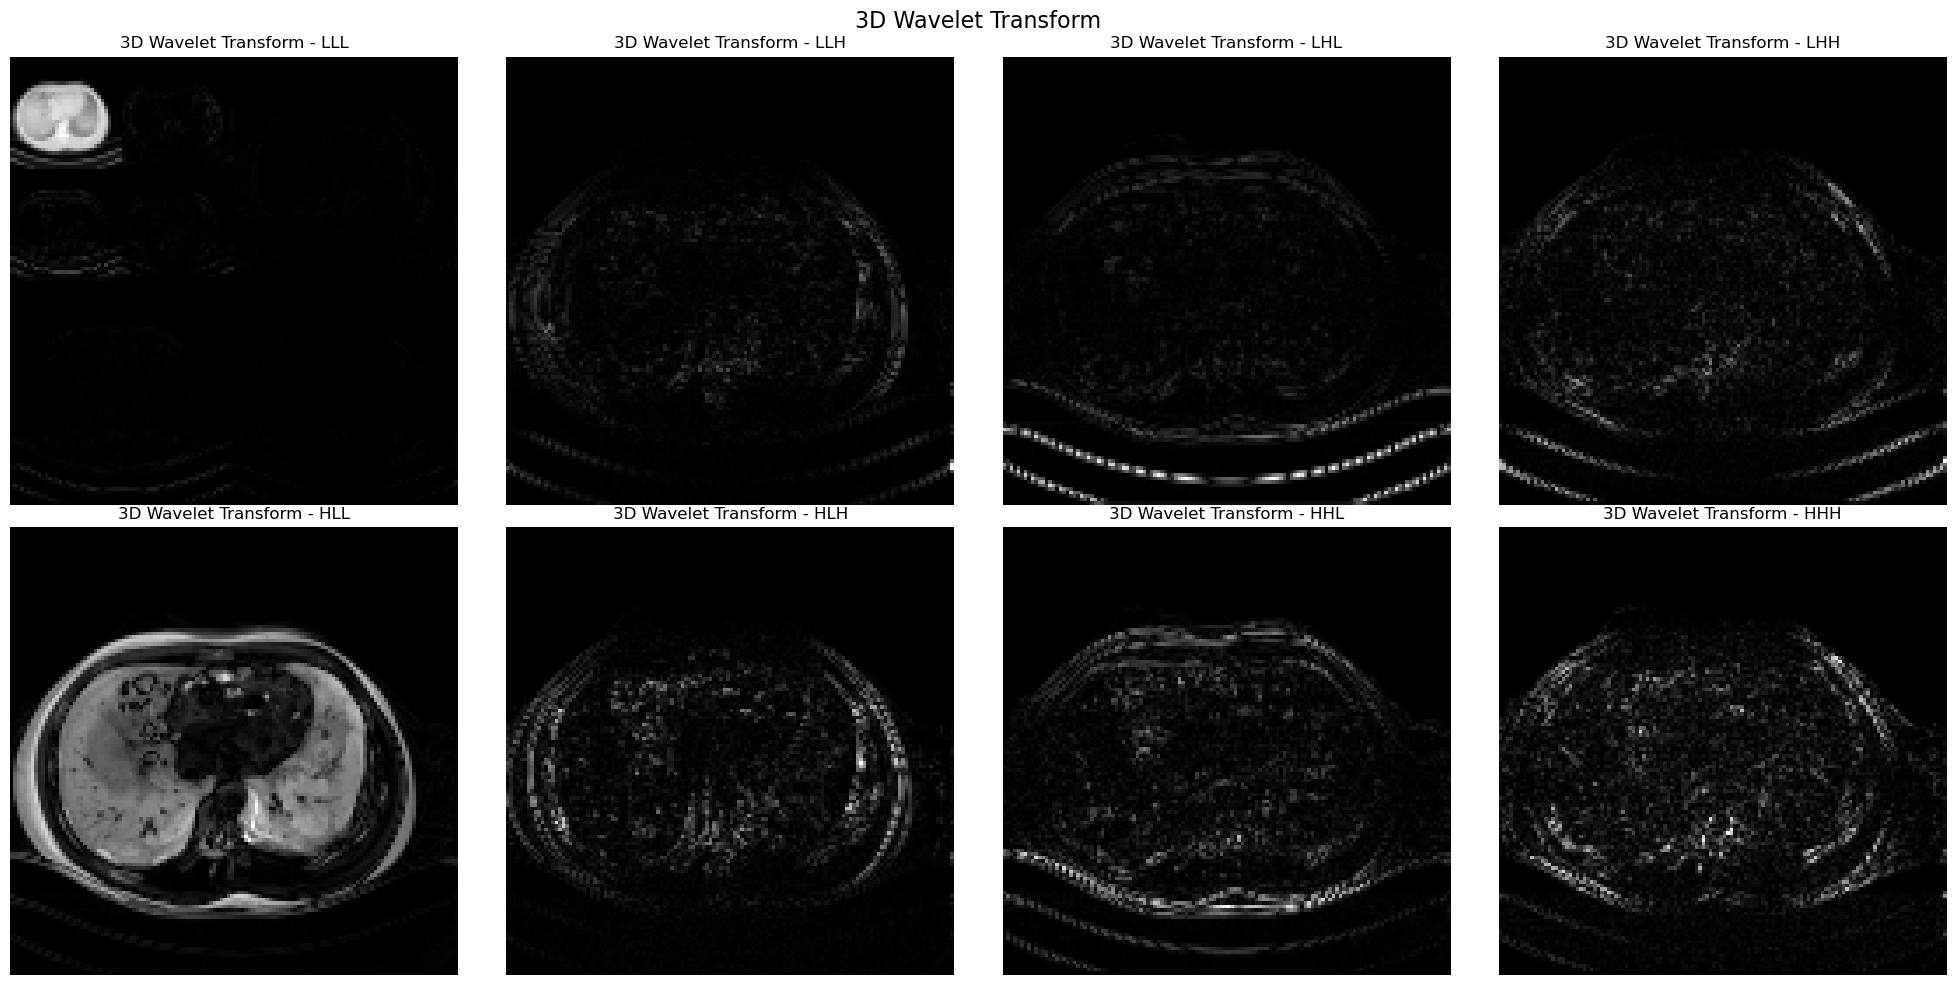

In [1160]:
# Extract the LLL subband from the first level
LLL_subband = data_cpp['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level2 = {
    'LLL': LLL_subband[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband[half_depth:, half_rows:, half_cols:]
}

# If the preivous level was the last, exit
if levels - 1 < 1:
    print("Finished Multi-Level Wavelet Transform")
    exit(1)

else:
    pywt = coeffs_pywt[levels-1]

    # If this is the last level, extract the aaa subband
    if levels - 1 == 1:
        pywt_aaa = coeffs_pywt[0]  # Extract the aaa subband

        # Add the aaa subband to pywt_level2 for display
        pywt['aaa'] = pywt_aaa

    # Display the images for the first level wavelet transform
    display_images(pywt, '3D Wavelet Transform (PyWavelets)', keys=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'], slice=slice)

    # Display the C++ implementation's subbands related to this level 
    display_images(subbands_level2, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'], slice=slice)

In [1161]:
# Copy the data to new arrays
data_cpp_copy = {key: np.copy(value) for key, value in subbands_level2.items()}
coeffs_pywt_copy = {key: np.copy(value) for key, value in pywt.items()}

# Normalise the pywavelets data
for key in coeffs_pywt_copy:
    coeffs_pywt_copy[key] = normalise_data(coeffs_pywt_copy[key])

# Normalise the data
for key in data_cpp_copy:
    data_cpp_copy[key] = normalise_data(data_cpp_copy[key])

# Mapping between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare pywavlets and C++ results
total_energy_cpp = 0
total_energy_pywt = 0
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data_copy = data_cpp_copy[cpp_key]
        pywt_data_copy = coeffs_pywt_copy[pywt_key]
        
        # Pad arrays to match shapes if necessary
        if cpp_data_copy.shape != pywt_data_copy.shape:
            if cpp_data_copy.shape < pywt_data_copy.shape:
                cpp_data_copy = pad(cpp_data_copy, pywt_data_copy.shape)
            else:
                pywt_data_copy = pad(pywt_data_copy, cpp_data_copy.shape)
        
        mse = np.mean((cpp_data_copy - pywt_data_copy) ** 2)
        print(f"MSE for {cpp_key}: {mse}")
        
        # Calculate total energy
        total_energy_cpp += np.sum(cpp_data_copy ** 2)
        total_energy_pywt += np.sum(pywt_data_copy ** 2)
    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")

# Calculate MSE of total energy
total_energy_mse = np.mean((total_energy_cpp - total_energy_pywt) ** 2)
print(f"\nMSE of total energy: {total_energy_mse}")

KeyError: 'aaa' for key LLL
MSE for LLH: 2.7466793060302734
MSE for LHL: 3.014258861541748
MSE for LHH: 1.708335518836975
MSE for HLL: 1.8180015087127686
MSE for HLH: 2.027841091156006
MSE for HHL: 2.029231071472168
MSE for HHH: 1.9099518060684204

MSE of total energy: 4294959104.0039062


In [1162]:
print ("Resolution of subbands from PyWavelets:")

for key, value in pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

print ("\nResolution of subbands from C++:")

for key, value in subbands_level2.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subbands from PyWavelets:
Resolution of subband aad: (20, 128, 128)
Resolution of subband ada: (20, 128, 128)
Resolution of subband add: (20, 128, 128)
Resolution of subband daa: (20, 128, 128)
Resolution of subband dad: (20, 128, 128)
Resolution of subband dda: (20, 128, 128)
Resolution of subband ddd: (20, 128, 128)

Resolution of subbands from C++:
Resolution of subband LLL: (20, 128, 128)
Resolution of subband LLH: (20, 128, 128)
Resolution of subband LHL: (20, 128, 128)
Resolution of subband LHH: (20, 128, 128)
Resolution of subband HLL: (19, 128, 128)
Resolution of subband HLH: (19, 128, 128)
Resolution of subband HHL: (19, 128, 128)
Resolution of subband HHH: (19, 128, 128)


Key 'aaa' not found in data


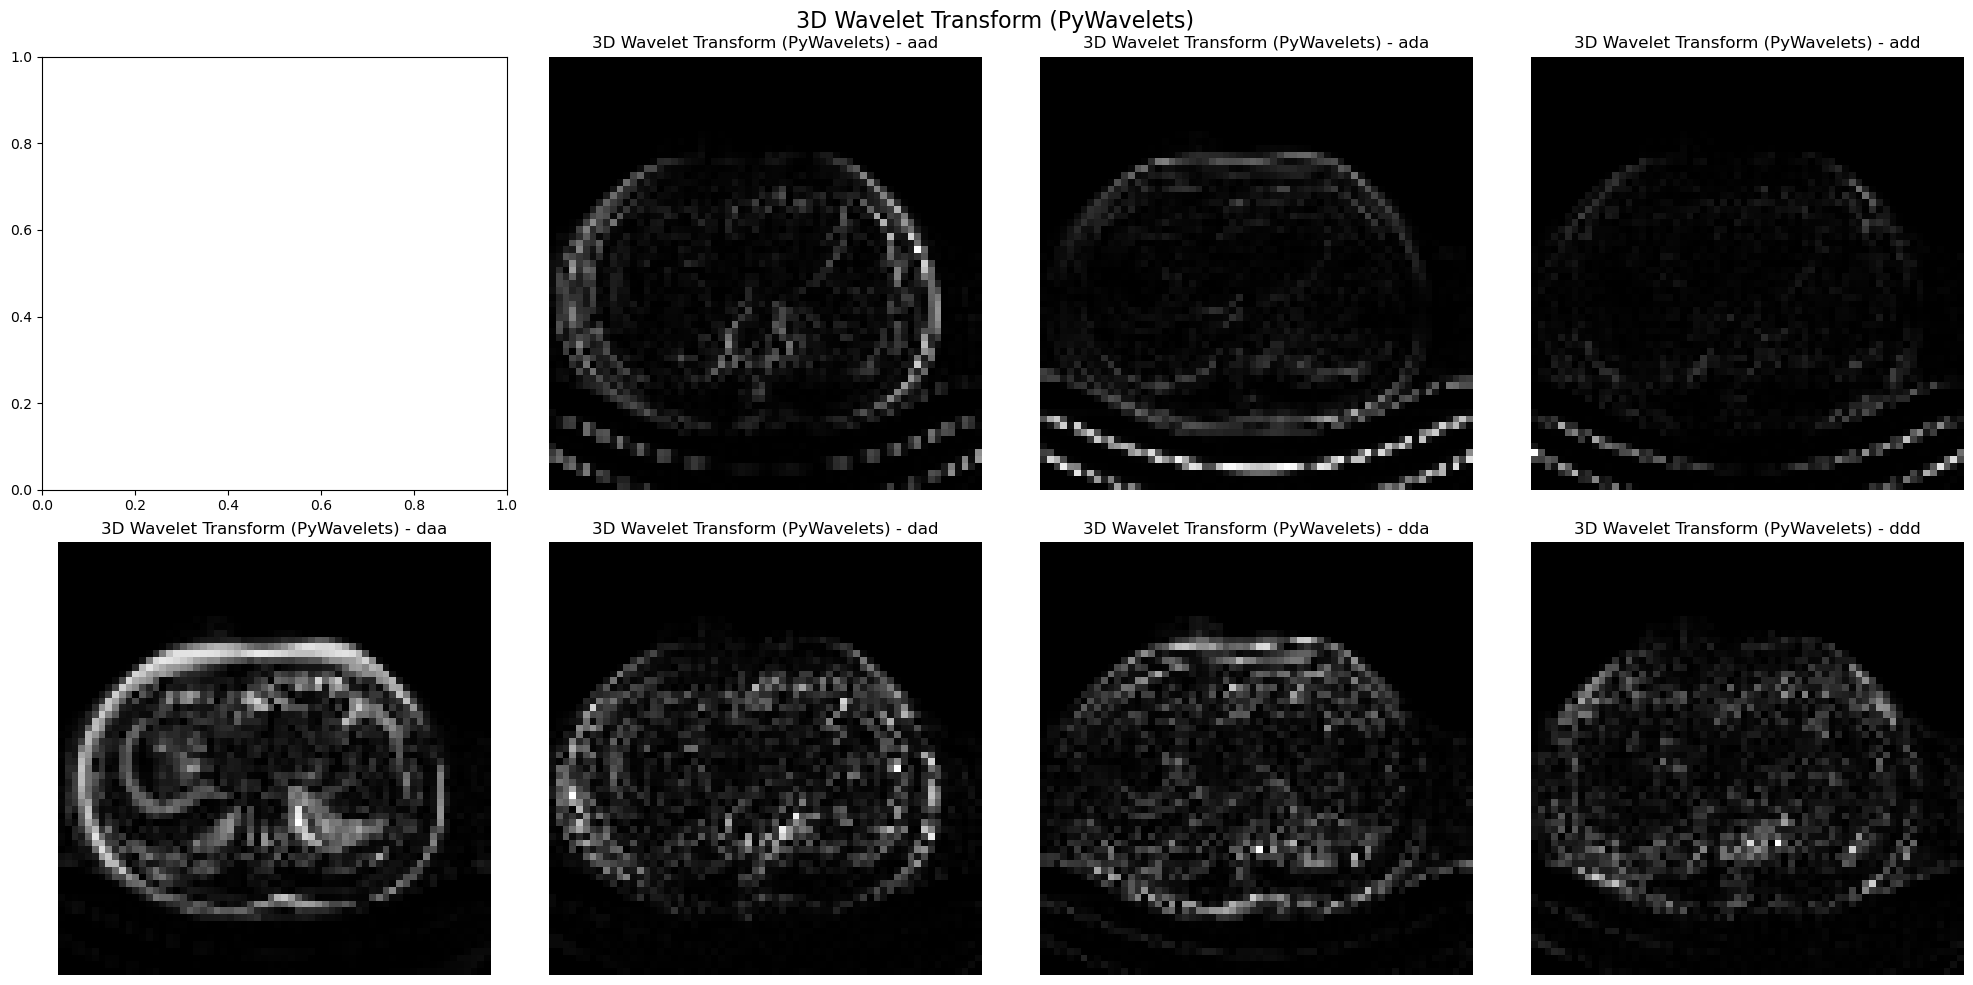

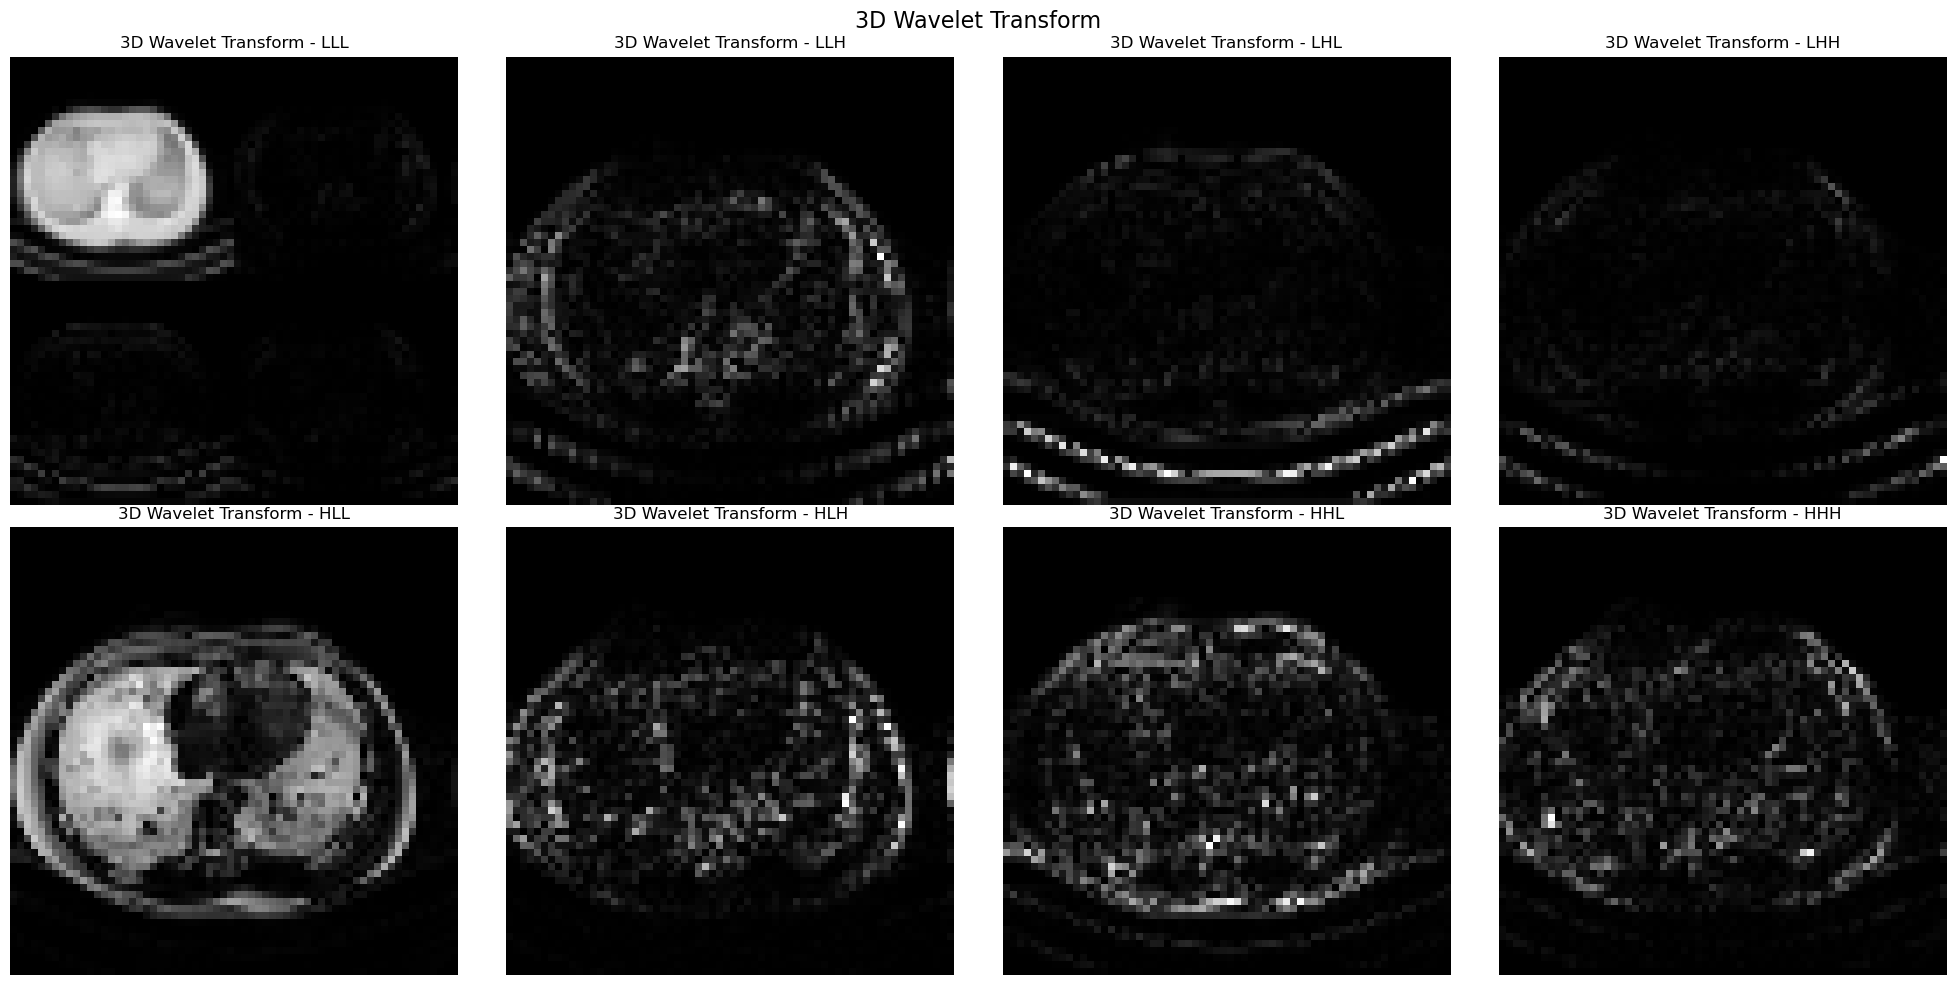

In [1163]:
# Extract the LLL subband from the first level
LLL_subband1 = subbands_level2['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband1.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level3 = {
    'LLL': LLL_subband1[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband1[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband1[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband1[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband1[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband1[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband1[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband1[half_depth:, half_rows:, half_cols:]
}

if levels - 2 < 1:
    print("Finished Multi-Level Wavelet Transform")
    exit(1)

else:
    pywt = coeffs_pywt[levels-2]

    if levels - 2 == 1:
        pywt_aaa = coeffs_pywt[0]  # Extract the aaa subband

        # Add the aaa subband to pywt_level2 for display
        pywt['aaa'] = pywt_aaa

    # Display the images for the first level wavelet transform
    display_images(pywt, '3D Wavelet Transform (PyWavelets)', keys=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'], slice=slice)

    # Display the C++ implementation's subbands related to this level 
    display_images(subbands_level3, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'], slice=slice)

In [1164]:
# Copy the data to new arrays
data_cpp_copy = {key: np.copy(value) for key, value in subbands_level3.items()}
coeffs_pywt_copy = {key: np.copy(value) for key, value in pywt.items()}

# Normalise the pywavelets data
for key in coeffs_pywt_copy:
    coeffs_pywt_copy[key] = normalise_data(coeffs_pywt_copy[key])

# Normalise the data
for key in data_cpp_copy:
    data_cpp_copy[key] = normalise_data(data_cpp_copy[key])

# Map between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare pywavlets and C++ results
total_energy_cpp = 0
total_energy_pywt = 0
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data_copy = data_cpp_copy[cpp_key]
        pywt_data_copy = coeffs_pywt_copy[pywt_key]
        
        # Pad arrays to match shapes if necessary
        if cpp_data_copy.shape != pywt_data_copy.shape:
            if cpp_data_copy.shape < pywt_data_copy.shape:
                cpp_data_copy = pad(cpp_data_copy, pywt_data_copy.shape)
            else:
                pywt_data_copy = pad(pywt_data_copy, cpp_data_copy.shape)
        
        mse = np.mean((cpp_data_copy - pywt_data_copy) ** 2)
        print(f"MSE for {cpp_key}: {mse}")
        
        # Calculate total energy
        total_energy_cpp += np.sum(cpp_data_copy ** 2)
        total_energy_pywt += np.sum(pywt_data_copy ** 2)
    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")

# Calculate MSE of total energy
total_energy_mse = np.mean((total_energy_cpp - total_energy_pywt) ** 2)
print(f"\nMSE of total energy: {total_energy_mse}")

KeyError: 'aaa' for key LLL
MSE for LLH: 2.7564642429351807
MSE for LHL: 2.2443149089813232
MSE for LHH: 2.1849467754364014
MSE for HLL: 2.052952289581299
MSE for HLH: 2.006011486053467
MSE for HHL: 1.9860050678253174
MSE for HHH: 1.96479070186615

MSE of total energy: 0.0001373291015625


In [1165]:
print ("Resolution of subbands from PyWavelets:")

# Printing the resolution of the subbands
for key, value in pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

print ("\nResolution of subbands from C++:")

for key, value in subbands_level3.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subbands from PyWavelets:
Resolution of subband aad: (10, 64, 64)
Resolution of subband ada: (10, 64, 64)
Resolution of subband add: (10, 64, 64)
Resolution of subband daa: (10, 64, 64)
Resolution of subband dad: (10, 64, 64)
Resolution of subband dda: (10, 64, 64)
Resolution of subband ddd: (10, 64, 64)

Resolution of subbands from C++:
Resolution of subband LLL: (10, 64, 64)
Resolution of subband LLH: (10, 64, 64)
Resolution of subband LHL: (10, 64, 64)
Resolution of subband LHH: (10, 64, 64)
Resolution of subband HLL: (10, 64, 64)
Resolution of subband HLH: (10, 64, 64)
Resolution of subband HHL: (10, 64, 64)
Resolution of subband HHH: (10, 64, 64)


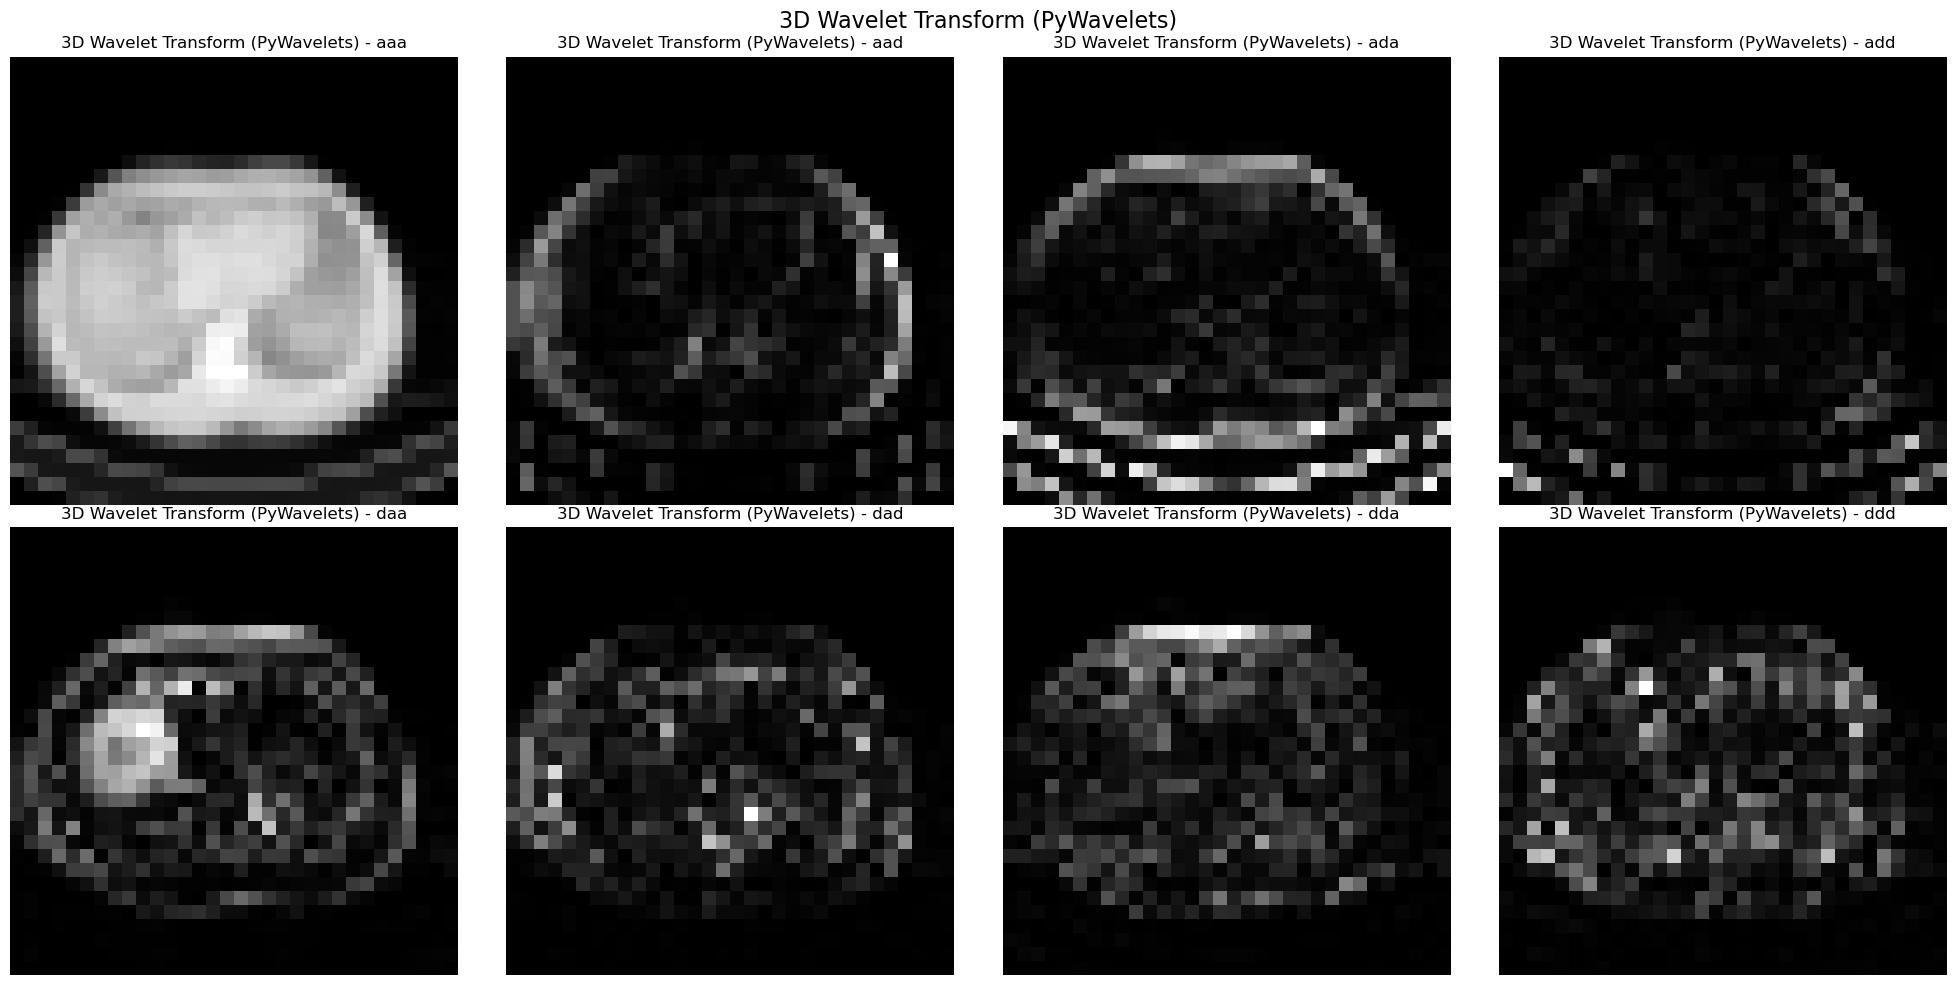

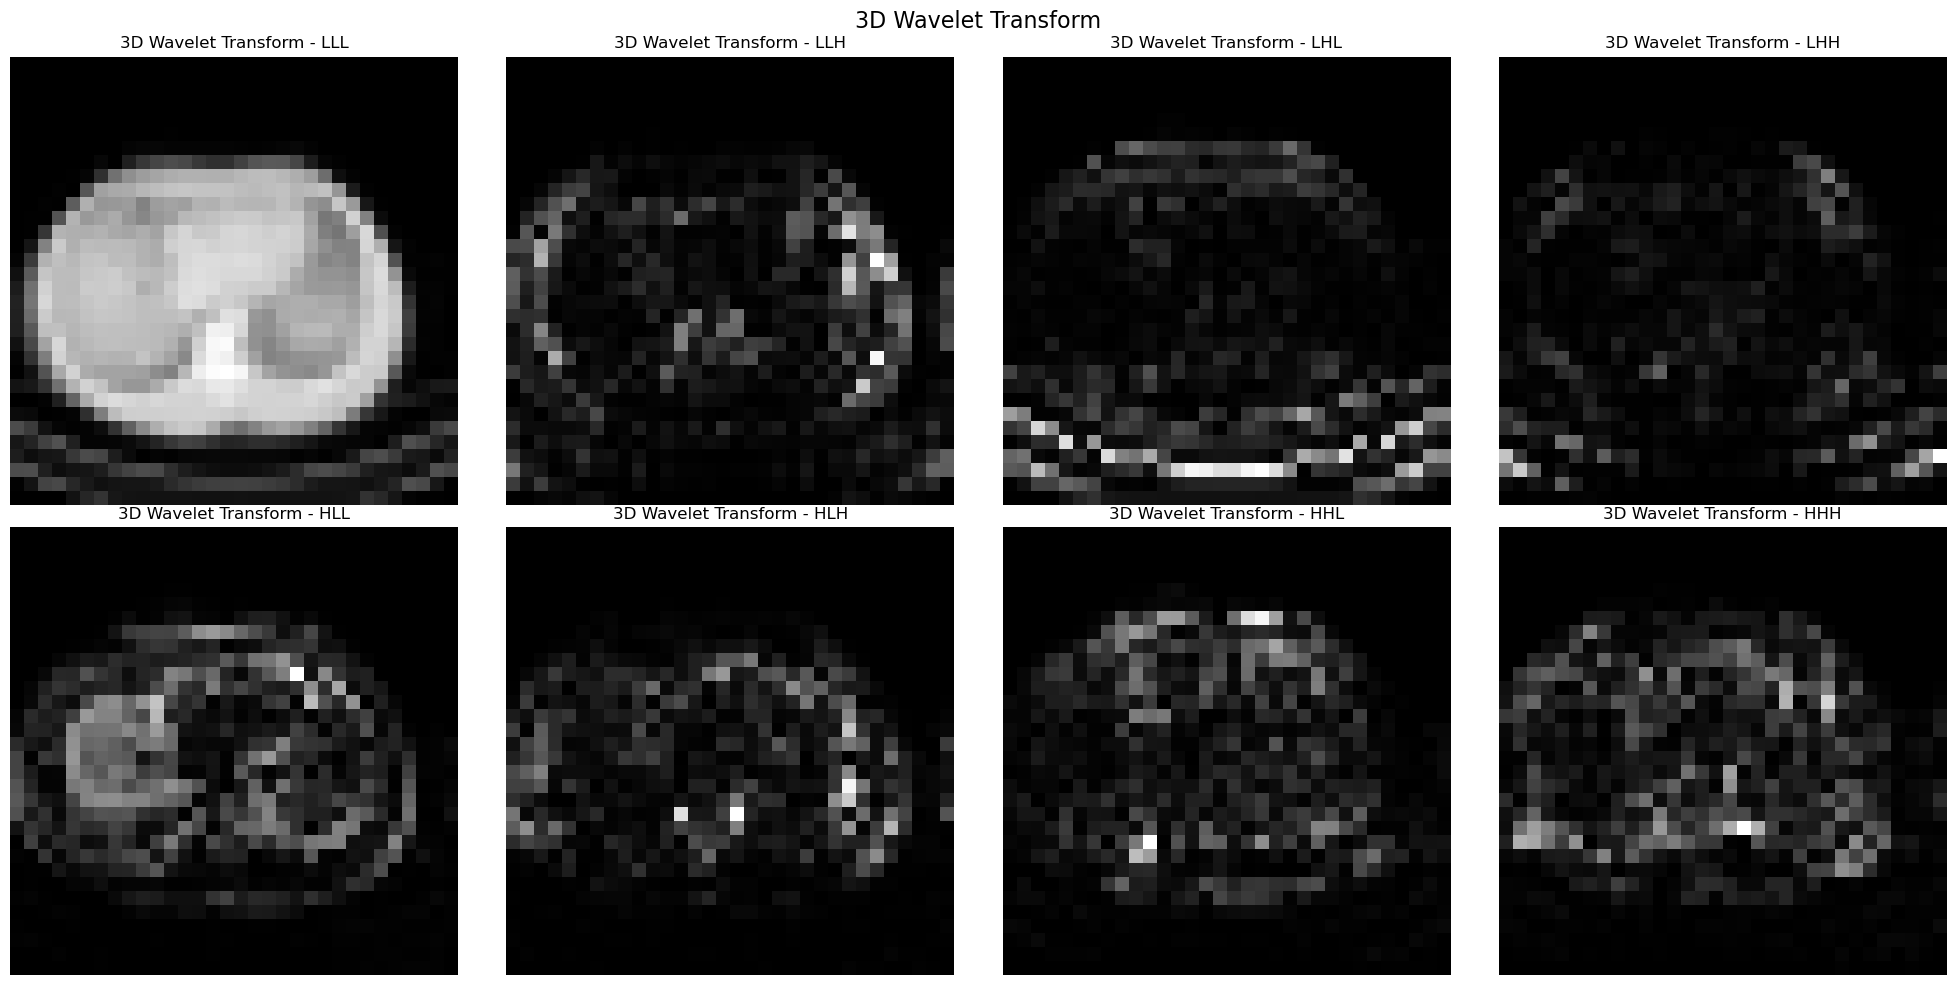

In [1166]:
# Extract the LLL subband from the first level
LLL_subband2 = subbands_level3['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband2.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level4 = {
    'LLL': LLL_subband2[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband2[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband2[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband2[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband2[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband2[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband2[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband2[half_depth:, half_rows:, half_cols:]
}

# If the preivous level was the last, exit
if levels - 3 < 1:
    print("Finished Multi-Level Wavelet Transform")
    exit(1)

else:
    pywt = coeffs_pywt[levels-3]

    if levels - 3 == 1:
        pywt_aaa = coeffs_pywt[0]  # Extract the aaa subband

        # Add the aaa subband to pywt for display
        pywt['aaa'] = pywt_aaa

        # Display the images for the first level wavelet transform
    display_images(pywt, '3D Wavelet Transform (PyWavelets)', keys=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'], slice=slice)

    # Display the C++ implementation's subbands related to this level 
    display_images(subbands_level4, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'], slice=slice)

In [1167]:
# Copy the data to new arrays
data_cpp_copy = {key: np.copy(value) for key, value in subbands_level4.items()}
coeffs_pywt_copy = {key: np.copy(value) for key, value in pywt.items()}

# Normalise the pywavelets data
for key in coeffs_pywt_copy:
    coeffs_pywt_copy[key] = normalise_data(coeffs_pywt_copy[key])

# Normalise the data
for key in data_cpp_copy:
    data_cpp_copy[key] = normalise_data(data_cpp_copy[key])

# Mapping between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare pywavlets and C++ results
total_energy_cpp = 0
total_energy_pywt = 0
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data_copy = data_cpp_copy[cpp_key]
        pywt_data_copy = coeffs_pywt_copy[pywt_key]
        
        # Pad arrays to match shapes if necessary
        if cpp_data_copy.shape != pywt_data_copy.shape:
            if cpp_data_copy.shape < pywt_data_copy.shape:
                cpp_data_copy = pad(cpp_data_copy, pywt_data_copy.shape)
            else:
                pywt_data_copy = pad(pywt_data_copy, cpp_data_copy.shape)
        
        mse = np.mean((cpp_data_copy - pywt_data_copy) ** 2)
        print(f"MSE for {cpp_key}: {mse}")
        
        # Calculate total energy
        total_energy_cpp += np.sum(cpp_data_copy ** 2)
        total_energy_pywt += np.sum(pywt_data_copy ** 2)
    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")

# Calculate MSE of total energy
total_energy_mse = np.mean((total_energy_cpp - total_energy_pywt) ** 2)
print(f"\nMSE of total energy: {total_energy_mse}")

MSE for LLL: 0.049447815865278244
MSE for LLH: 2.877257823944092
MSE for LHL: 2.3185336589813232
MSE for LHH: 2.1391663551330566
MSE for HLL: 1.4862524271011353
MSE for HLH: 2.1484992504119873
MSE for HHL: 2.046149730682373
MSE for HHH: 1.9980770349502563

MSE of total energy: 9.5367431640625e-07


In [1168]:
print ("Resolution of subbands from PyWavelets:")

# Printing the resolution of the subbands
for key, value in pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

print ("\nResolution of subbands from C++:")

for key, value in subbands_level4.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subbands from PyWavelets:
Resolution of subband aad: (5, 32, 32)
Resolution of subband ada: (5, 32, 32)
Resolution of subband add: (5, 32, 32)
Resolution of subband daa: (5, 32, 32)
Resolution of subband dad: (5, 32, 32)
Resolution of subband dda: (5, 32, 32)
Resolution of subband ddd: (5, 32, 32)
Resolution of subband aaa: (5, 32, 32)

Resolution of subbands from C++:
Resolution of subband LLL: (5, 32, 32)
Resolution of subband LLH: (5, 32, 32)
Resolution of subband LHL: (5, 32, 32)
Resolution of subband LHH: (5, 32, 32)
Resolution of subband HLL: (5, 32, 32)
Resolution of subband HLH: (5, 32, 32)
Resolution of subband HHL: (5, 32, 32)
Resolution of subband HHH: (5, 32, 32)
